In [1]:
import os
import json
import requests
import polars as pl
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from bs4 import BeautifulSoup

In [2]:
DATA_PATH = "../../data/raw/"

In [3]:
try:
    os.mkdir(DATA_PATH + "met_paintings/")
except FileExistsError:
    pass

In [4]:
met_data = pl.read_csv(DATA_PATH + "met_objects.csv", ignore_errors=True)
met_data.head()

Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Constituent ID,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
str,bool,bool,bool,i64,i64,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""1979.486.1""",false,false,false,1,null,"""The American Wing""",1979,"""Coin""","""One-dollar Liberty Head Coin""",null,null,null,null,null,16429,"""Maker""",""" ""","""James Barton Longacre""","""American, Delaware County, Pen…",""" ""","""Longacre, James Barton""","""American""","""1794 ""","""1869 """,null,"""http://vocab.getty.edu/page/ul…","""https://www.wikidata.org/wiki/…","""1853""",1853,1853,"""Gold""","""Dimensions unavailable""","""Gift of Heinz L. Stoppelmann, …",null,null,null,null,null,null,null,null,null,null,null,null,null,"""http://www.metmuseum.org/art/c…",null,null,"""Metropolitan Museum of Art, Ne…",null,null,null
"""1980.264.5""",false,false,false,2,null,"""The American Wing""",1980,"""Coin""","""Ten-dollar Liberty Head Coin""",null,null,null,null,null,107,"""Maker""",""" ""","""Christian Gobrecht""","""1785–1844""",""" ""","""Gobrecht, Christian""","""American""","""1785 ""","""1844 """,null,"""http://vocab.getty.edu/page/ul…","""https://www.wikidata.org/wiki/…","""1901""",1901,1901,"""Gold""","""Dimensions unavailable""","""Gift of Heinz L. Stoppelmann, …",null,null,null,null,null,null,null,null,null,null,null,null,null,"""http://www.metmuseum.org/art/c…",null,null,"""Metropolitan Museum of Art, Ne…",null,null,null
"""67.265.9""",false,false,false,3,null,"""The American Wing""",1967,"""Coin""","""Two-and-a-Half Dollar Coin""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""1909–27""",1909,1927,"""Gold""","""Diam. 11/16 in. (1.7 cm)""","""Gift of C. Ruxton Love Jr., 19…",null,null,null,null,null,null,null,null,null,null,null,null,null,"""http://www.metmuseum.org/art/c…",null,null,"""Metropolitan Museum of Art, Ne…",null,null,null
"""67.265.10""",false,false,false,4,null,"""The American Wing""",1967,"""Coin""","""Two-and-a-Half Dollar Coin""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""1909–27""",1909,1927,"""Gold""","""Diam. 11/16 in. (1.7 cm)""","""Gift of C. Ruxton Love Jr., 19…",null,null,null,null,null,null,null,null,null,null,null,null,null,"""http://www.metmuseum.org/art/c…",null,null,"""Metropolitan Museum of Art, Ne…",null,null,null
"""67.265.11""",false,false,false,5,null,"""The American Wing""",1967,"""Coin""","""Two-and-a-Half Dollar Coin""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""1909–27""",1909,1927,"""Gold""","""Diam. 11/16 in. (1.7 cm)""","""Gift of C. Ruxton Love Jr., 19…",null,null,null,null,null,null,null,null,null,null,null,null,null,"""http://www.metmuseum.org/art/c…",null,null,"""Metropolitan Museum of Art, Ne…",null,null,null


In [5]:
met_european_paintings = met_data.filter((pl.col("Department") == "European Paintings") & (pl.col("Is Public Domain") == True) & (pl.col("Object End Date") > 1201) & (pl.col("Object End Date") < 2001))
european_paintings_urls = met_european_paintings[["Title", "Artist Display Name", "Object End Date", "Link Resource"]].to_numpy()
european_paintings_urls

array([['A Ship in a Stormy Sea',
        'Ivan Konstantinovich Aivazovsky (Hovhannes Aivazian)', 1900,
        'http://www.metmuseum.org/art/collection/search/435570'],
       ['Saint Giles with Christ Triumphant over Satan and the Mission of the Apostles',
        'Miguel Alcañiz (or Miquel Alcanyís)', 1413,
        'http://www.metmuseum.org/art/collection/search/435572'],
       ['Flora and Zephyr', 'Jacopo Amigoni', 1739,
        'http://www.metmuseum.org/art/collection/search/435573'],
       ...,
       ['A Man Seated and Asleep', 'Giuseppe Abbati', 1870,
        'http://www.metmuseum.org/art/collection/search/872016'],
       ['Rachel Ruysch (1664–1750)',
        'Michiel van Musscher|Rachel Ruysch', 1692,
        'http://www.metmuseum.org/art/collection/search/875634'],
       ['Still Life with a Vase of Flowers, Melon, Peaches, and Grapes',
        'Charlotte Eustache Sophie de Fuligny Damas, marquise de Grollier',
        1780, 'http://www.metmuseum.org/art/collection/search/

In [ ]:
# the first 730 were processed

In [6]:
paintings_data = []

for painting_id, (title, artist, year, painting_url) in enumerate(tqdm(european_paintings_urls)):
    # Send a request to the page
    response = requests.get(painting_url)
    response.raise_for_status()  # Check if the request was successful

    description = ""

    # Parse the page content
    soup = BeautifulSoup(response.text, "html.parser")
    brief_description = soup.find("div", {"class": "artwork__intro__desc js-artwork__intro__desc"}).get_text().strip()

    if len(brief_description) > 0:
        description += brief_description + "\n"

    try:
        catalog_entry = (
            soup.find("section", {"id": "catalogue-entry"})
            .find("div", class_="show-more__body js-show-more__body")
            .get_text()
            .strip()
        )
        description += catalog_entry
    except AttributeError:
        pass

    if len(description) > 0:
        image_url = soup.find("meta", {"property": "og:image"})["content"]
        image = requests.get(image_url).content

        paintings_data.append({"id": painting_id, "title": title, "artist": artist, "year": year, "description": description})

        with open(DATA_PATH + f'{painting_id}.png', 'wb') as handler:
            handler.write(image)

 31%|███▏      | 731/2327 [19:26<42:26,  1.60s/it]  


HTTPError: 403 Client Error: Forbidden for url: http://www3.metmuseum.org/error-page-404

In [8]:
with open(DATA_PATH + "met_paintings_data.json", 'w') as json_file:
    json.dump(paintings_data, json_file, indent=4)  

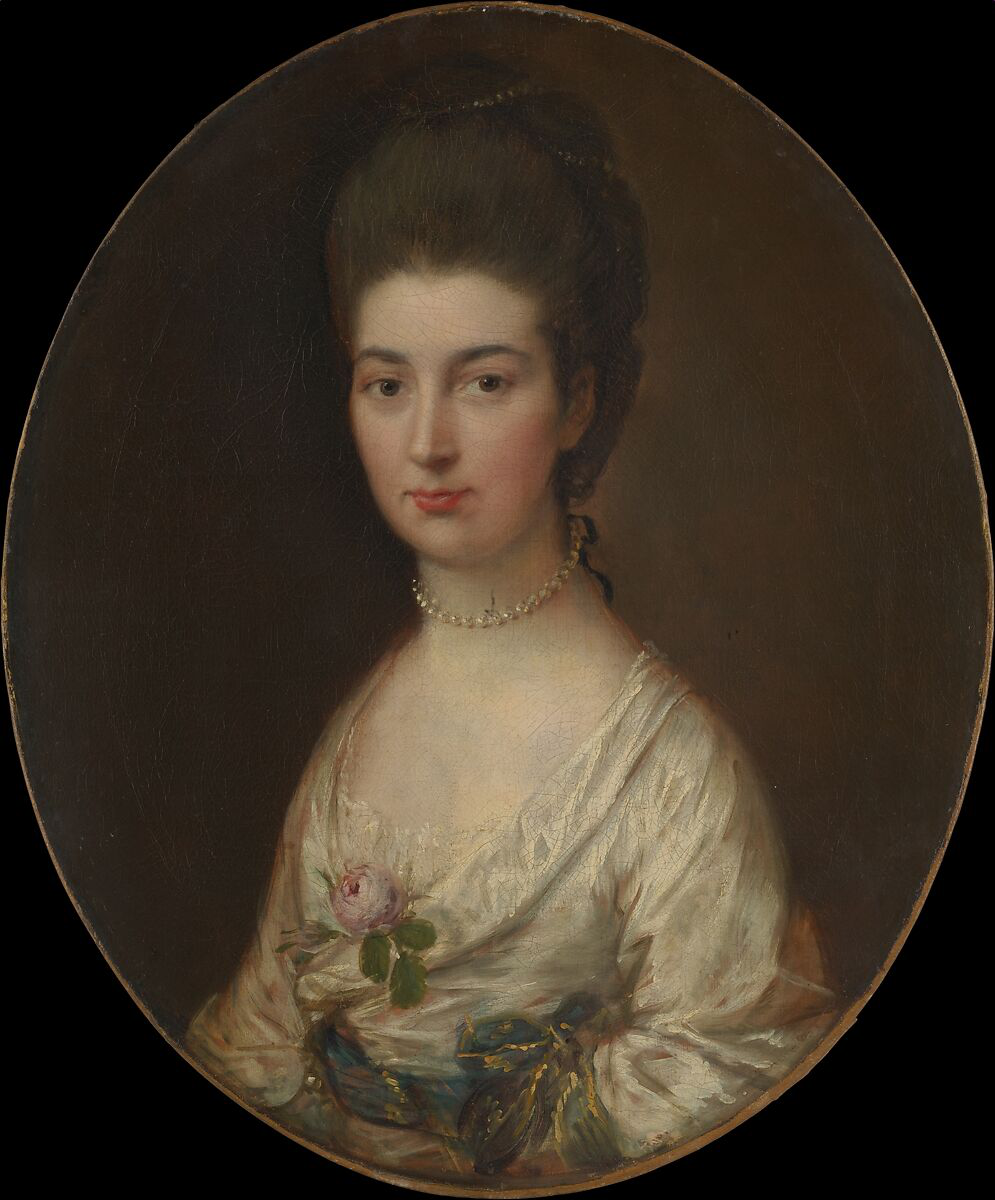

In [9]:
Image.open(BytesIO(image))